# Using batch prediction feature with Keras models on AI Platform

## Functional API example

**Note: use "TensorFlow Enterprise 2.3" instance to run this notebook.**

Define environment variables and create a strage bucket.

In [1]:
# change these to try this notebook out
BUCKET = 'enakai-ml-pipeline2-2'
PROJECT = 'enakai-ml-pipeline2'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
    gsutil mb -l ${REGION} gs://${BUCKET}
fi

Import modules and prepare training data. (You use the [Bouston Housing price regression dataset](https://keras.io/api/datasets/boston_housing/#load_data-function) as an example.)

In [4]:
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models, datasets

In [5]:
(x_train, y_train), (x_test, y_test) = datasets.boston_housing.load_data(
    path="boston_housing.npz", test_split=0.2, seed=113
)

In [6]:
df = DataFrame(x_train)
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


Create a model to predict average prices and train it.

In [7]:
model = models.Sequential()
model.add(layers.Input(shape=(13,), name='features'))
model.add(layers.Dense(8, activation='relu', name='hidden'))
model.add(layers.Dense(1, activation=None, name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 8)                 112       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='mse')

Training will take a few minutes...

In [9]:
history = model.fit(
    x_train, y_train, validation_data=(x_test, y_test),
    batch_size=64, epochs=1000, verbose=0)

<AxesSubplot:>

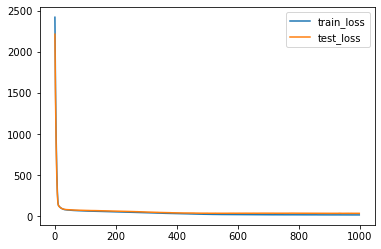

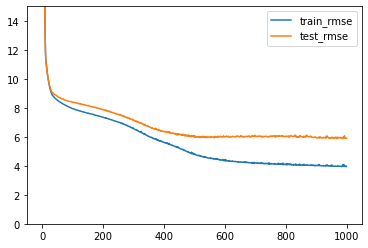

In [10]:
DataFrame({'train_loss': history.history['loss'], 
           'test_loss': history.history['val_loss']}).plot()
DataFrame({'train_rmse': np.sqrt(history.history['loss']), 
           'test_rmse': np.sqrt(history.history['val_loss'])}).plot(ylim=[0, 15])

Create a wrapper model so that you can add an identifier key to each example.

In [11]:
key = layers.Input(shape=(), name='key', dtype='int32')
pred = layers.Concatenate(name='prediction_with_key')(
    [model.output, tf.cast(layers.Reshape((1,))(key), tf.float32)])
wrapper_model = models.Model(inputs=[model.input, key], outputs=pred)
wrapper_model.compile()
wrapper_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
features (InputLayer)           [(None, 13)]         0                                            
__________________________________________________________________________________________________
key (InputLayer)                [(None,)]            0                                            
__________________________________________________________________________________________________
hidden (Dense)                  (None, 8)            112         features[0][0]                   
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1)            0           key[0][0]                        
_______________________________________________________________________________________

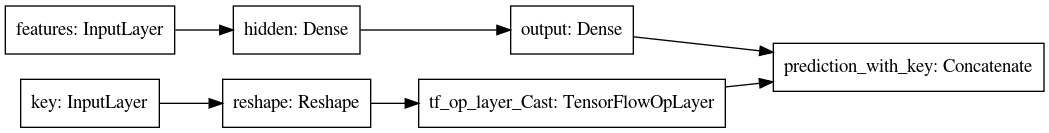

In [12]:
tf.keras.utils.plot_model(
    model=wrapper_model, to_file="dnn_model.png", show_shapes=False, rankdir="LR")

Use the predict method of the wrapper model.

In [13]:
wrapper_model.predict([x_test[:10], tf.constant(range(10))])

array([[11.821846,  0.      ],
       [18.870054,  1.      ],
       [22.98235 ,  2.      ],
       [34.027252,  3.      ],
       [23.004887,  4.      ],
       [20.938322,  5.      ],
       [30.731697,  6.      ],
       [22.495346,  7.      ],
       [18.957079,  8.      ],
       [16.742697,  9.      ]], dtype=float32)

Export the wrapper model in the saved_model format.

In [14]:
export_path = "./export"
wrapper_model.save(export_path, save_format='tf')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./export/assets


In [15]:
%%bash
saved_model_cli show --dir "./export" --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['features'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 13)
      name: serving_default_features:0
  inputs['key'] tensor_info:
      dtype: DT_INT32
      shape: (-1)
      name: serving_default_key:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['prediction_with_key'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


Make local predictions with the exported model.

In [16]:
serving_fn = models.load_model(export_path).signatures['serving_default']
serving_fn(features=tf.constant(x_test[:10].tolist()), key=tf.constant(range(10)))

{'prediction_with_key': <tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[11.821846,  0.      ],
        [18.870054,  1.      ],
        [22.98235 ,  2.      ],
        [34.027252,  3.      ],
        [23.004887,  4.      ],
        [20.938322,  5.      ],
        [30.731697,  6.      ],
        [22.495346,  7.      ],
        [18.957079,  8.      ],
        [16.742697,  9.      ]], dtype=float32)>}

Deploy the exported model to AI Platform.

**Note**: the latest runtime that supports batch prediction is 2.1

https://cloud.google.com/ai-platform/training/docs/runtime-version-list

In [18]:
%%bash
MODEL_NAME="housing_price"
MODEL_VERSION="v1"
MODEL_LOCATION="./export"
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} \
  --origin ${MODEL_LOCATION} --runtime-version 2.1 \
  --staging-bucket gs://$BUCKET --region global

Using endpoint [https://ml.googleapis.com/]
Created ml engine model [projects/enakai-ml-pipeline2/models/housing_price].
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......
..........................................................................................................................................................................................................................................................................done.


Make online predictions with the deployed model.

In [19]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials, cache_discovery=False)

request_data =  {'instances':
  [
    {"features": [18.0846, 0, 18.1, 0, 0.679, 6.434, 100, 1.8347, 24, 666, 20.2, 27.25, 29.05], "key": 0},
    {"features": [0.12329, 0, 10.01, 0, 0.547, 5.913, 92.9, 2.3534, 6.0, 432, 17.8, 394.95, 16.21], "key": 1},
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'housing_price', 'v1')
response = api.projects().predict(body=request_data, name=parent).execute()
print(json.dumps(response, sort_keys = True, indent = 4))

{
    "predictions": [
        {
            "prediction_with_key": [
                11.821846961975098,
                0.0
            ]
        },
        {
            "prediction_with_key": [
                18.870054244995117,
                1.0
            ]
        }
    ]
}


Create an input file and execute a batch prediction job.

In [20]:
with open('./input.json', 'w') as f:
    for features, key in zip(x_test[:10].tolist(), np.arange(10).tolist()):
        print(json.dumps({'features': features, 'key':key}), file=f)

In [21]:
%%bash
gsutil cp ./input.json gs://$BUCKET/input/input.json
gsutil cat gs://$BUCKET/input/input.json

{"features": [18.0846, 0.0, 18.1, 0.0, 0.679, 6.434, 100.0, 1.8347, 24.0, 666.0, 20.2, 27.25, 29.05], "key": 0}
{"features": [0.12329, 0.0, 10.01, 0.0, 0.547, 5.913, 92.9, 2.3534, 6.0, 432.0, 17.8, 394.95, 16.21], "key": 1}
{"features": [0.05497, 0.0, 5.19, 0.0, 0.515, 5.985, 45.4, 4.8122, 5.0, 224.0, 20.2, 396.9, 9.74], "key": 2}
{"features": [1.27346, 0.0, 19.58, 1.0, 0.605, 6.25, 92.6, 1.7984, 5.0, 403.0, 14.7, 338.92, 5.5], "key": 3}
{"features": [0.07151, 0.0, 4.49, 0.0, 0.449, 6.121, 56.8, 3.7476, 3.0, 247.0, 18.5, 395.15, 8.44], "key": 4}
{"features": [0.27957, 0.0, 9.69, 0.0, 0.585, 5.926, 42.6, 2.3817, 6.0, 391.0, 19.2, 396.9, 13.59], "key": 5}
{"features": [0.03049, 55.0, 3.78, 0.0, 0.484, 6.874, 28.1, 6.4654, 5.0, 370.0, 17.6, 387.97, 4.61], "key": 6}
{"features": [0.03551, 25.0, 4.86, 0.0, 0.426, 6.167, 46.7, 5.4007, 4.0, 281.0, 19.0, 390.64, 7.51], "key": 7}
{"features": [0.09299, 0.0, 25.65, 0.0, 0.581, 5.961, 92.9, 2.0869, 2.0, 188.0, 19.1, 378.09, 17.93], "key": 8}
{"fe

Copying file://./input.json [Content-Type=application/json]...
/ [1 files][  1.1 KiB/  1.1 KiB]                                                
Operation completed over 1 objects/1.1 KiB.                                      


In [22]:
%%bash
MODEL_NAME="housing_price"
MODEL_VERSION="v1"
JOB_NAME="batch_pred_$(date +'%Y%m%d%H%M%S')"
INPUT_PATHS="gs://$BUCKET/input/*"
OUTPUT_PATH="gs://$BUCKET/output"
DATA_FORMAT="text" # JSON data format
gcloud ai-platform jobs submit prediction $JOB_NAME \
    --model $MODEL_NAME \
    --input-paths $INPUT_PATHS \
    --output-path $OUTPUT_PATH \
    --region $REGION \
    --data-format $DATA_FORMAT

jobId: batch_pred_20210112075113
state: QUEUED


Job [batch_pred_20210112075113] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe batch_pred_20210112075113

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs batch_pred_20210112075113


In [23]:
!gsutil cat gs://$BUCKET/output/prediction.results*

CommandException: No URLs matched: gs://enakai-ml-pipeline2-2/output/prediction.results*
